In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Project-8/data.csv")
print("Data loaded successfully.")

# --- Initial Data Cleaning ---

# Convert published_date to datetime objects for time-series analysis
df['published_date'] = pd.to_datetime(df['published_date'])

# Create a unified salary column (for simplicity, we'll prioritize 'budget', then 'hourly_high')
df['salary'] = df['budget'].fillna(df['hourly_high'])

# Clean salary data (remove NaNs, non-numeric values)
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')
df_cleaned = df.dropna(subset=['salary', 'title'])

print(f"Original entries: {len(df)}, Cleaned entries: {len(df_cleaned)}")

Data loaded successfully.
Original entries: 244828, Cleaned entries: 202666


Task 1: Analyze correlation between job title keywords and offered salaries

--- Task 1: Keyword vs. Salary ---
     Keyword  Average_Salary
6      Sales     2500.253018
1   Engineer      754.350250
3    Manager      672.895453
0  Developer      672.209610
2    Analyst      455.936364
4   Designer      420.075439
5  Recruiter      419.364066


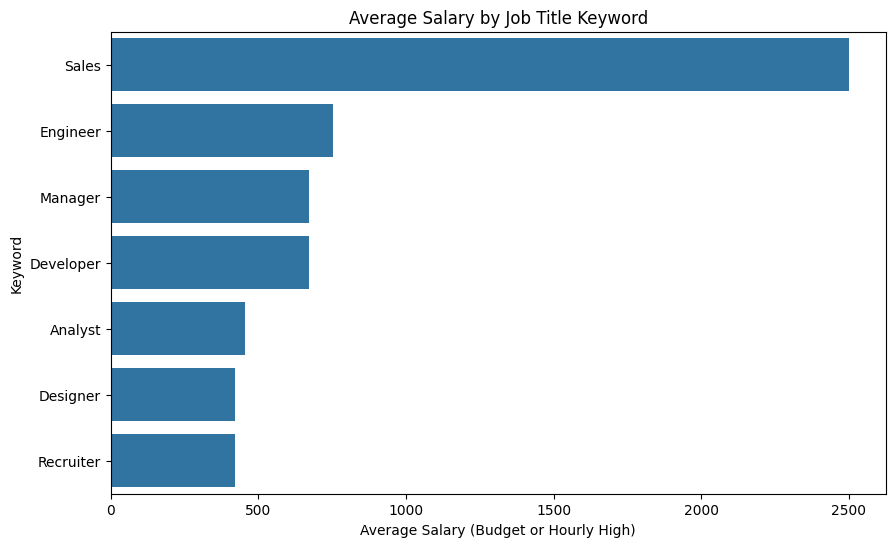

In [ ]:
# Define keywords to analyze
keywords = ['Developer', 'Engineer', 'Analyst', 'Manager', 'Designer', 'Recruiter', 'Sales']

keyword_salaries = {}

for keyword in keywords:
    # Find jobs containing the keyword (case-insensitive)
    keyword_df = df_cleaned[df_cleaned['title'].str.contains(keyword, case=False, na=False)]

    if not keyword_df.empty:
        # Calculate the mean salary for that keyword
        mean_salary = keyword_df['salary'].mean()
        keyword_salaries[keyword] = mean_salary

# Create a DataFrame for visualization
salary_corr_df = pd.DataFrame(list(keyword_salaries.items()), columns=['Keyword', 'Average_Salary'])
salary_corr_df = salary_corr_df.sort_values('Average_Salary', ascending=False)

print("--- Task 1: Keyword vs. Salary ---")
print(salary_corr_df)

# Visualize the results (as per deliverable [cite: 150134])
# Uses Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Average_Salary', y='Keyword', data=salary_corr_df)
plt.title('Average Salary by Job Title Keyword')
plt.xlabel('Average Salary (Budget or Hourly High)')
plt.ylabel('Keyword')
plt.show()

Task 2: Identify emerging job categories based on posting frequency


 Task 2: Emerging Job Trends (Monthly Frequency)
                              AI  Python  React  Full Stack  SMMA  Web3  \
published_date                                                            
2023-11-30 00:00:00+00:00      0       0      0           0     0     0   
2023-12-31 00:00:00+00:00      1       0      0           0     0     0   
2024-01-31 00:00:00+00:00      5       2      0           0     0     0   
2024-02-29 00:00:00+00:00   8655     892   1043         706    25   137   
2024-03-31 00:00:00+00:00  12259    1176   1616         968    55   230   

                           Developer  
published_date                        
2023-11-30 00:00:00+00:00          0  
2023-12-31 00:00:00+00:00          0  
2024-01-31 00:00:00+00:00          5  
2024-02-29 00:00:00+00:00       6673  
2024-03-31 00:00:00+00:00       9644  


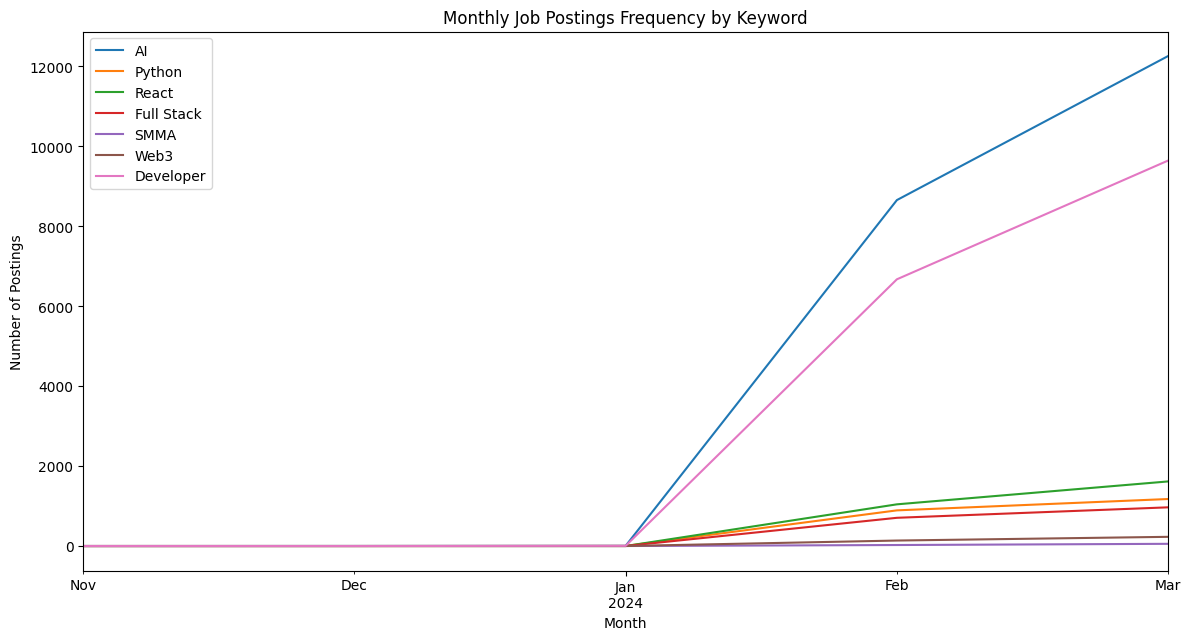

In [ ]:
# Keywords to track for emerging trends
emerging_keywords = ['AI', 'Python', 'React', 'Full Stack', 'SMMA', 'Web3', 'Developer']

# Set the 'published_date' as the index for time-series resampling
df_time = df.set_index('published_date')

monthly_trends = pd.DataFrame()

for keyword in emerging_keywords:
    # Count monthly occurrences of each keyword
    monthly_counts = df_time['title'].str.contains(keyword, case=False, na=False).resample('ME').sum()
    monthly_trends[keyword] = monthly_counts

print("\n Task 2: Emerging Job Trends (Monthly Frequency)")
print(monthly_trends.tail()) # Show last few months

# Visualize the trends (as per deliverable [cite: 150138])
# Uses Matplotlib
monthly_trends.plot(figsize=(14, 7), title='Monthly Job Postings Frequency by Keyword')
plt.ylabel('Number of Postings')
plt.xlabel('Month')
plt.legend(loc='upper left')
plt.show()

Task 3: Predict high-demand job roles


--- Task 3: Predicting Demand for 'Python' ---
Predicted counts for next 6 months: [1387 1711 2035 2360 2684 3009]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



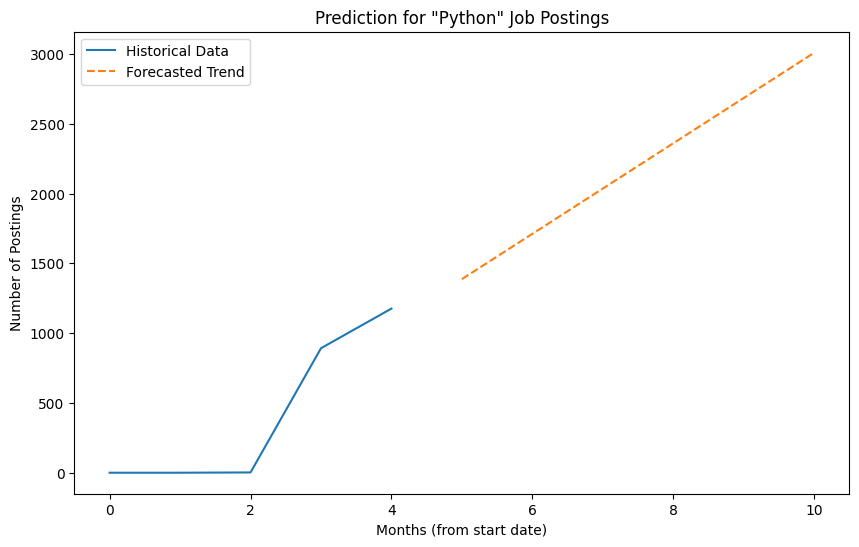

In [ ]:
# Let's predict the trend for 'Python'
trend_data = monthly_trends[['Python']].copy()
trend_data['time'] = np.arange(len(trend_data)) # Create a simple time feature

# Split data for training and prediction
X = trend_data[['time']]
y = trend_data['Python']

model = LinearRegression()
model.fit(X, y)

# Predict the next 6 months
future_time = np.arange(len(trend_data), len(trend_data) + 6).reshape(-1, 1)
future_predictions = model.predict(future_time)

print(f"\n--- Task 3: Predicting Demand for 'Python' ---")
print(f"Predicted counts for next 6 months: {future_predictions.astype(int)}")

# Visualize the prediction (as per deliverable [cite: 150140])
plt.figure(figsize=(10, 6))
plt.plot(X['time'], y, label='Historical Data')
plt.plot(future_time, future_predictions, label='Forecasted Trend', linestyle='--')
plt.title('Prediction for "Python" Job Postings')
plt.xlabel('Months (from start date)')
plt.ylabel('Number of Postings')
plt.legend()
plt.show()

Task 4: Compare average hourly rates across different countries

In [ ]:
# Clean hourly rate columns
df['hourly_low'] = pd.to_numeric(df['hourly_low'], errors='coerce')
df['hourly_high'] = pd.to_numeric(df['hourly_high'], errors='coerce')

# Calculate an average hourly rate
df['hourly_avg'] = (df['hourly_low'] + df['hourly_high']) / 2

# Group by country and calculate the mean average hourly rate
country_hourly_rate = df.dropna(subset=['hourly_avg', 'country']).groupby('country')['hourly_avg'].mean().reset_index()
country_hourly_rate = country_hourly_rate[country_hourly_rate['country'] != ''] # Remove empty country fields
country_hourly_rate = country_hourly_rate.sort_values('hourly_avg', ascending=False)

print("\n--- Task 4: Average Hourly Rate by Country ---")
print(country_hourly_rate.head(10))

# Create an interactive choropleth map using Plotly
fig = px.choropleth(country_hourly_rate,
                    locations="country",
                    locationmode="country names",
                    color="hourly_avg",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Average Hourly Rates by Country")
fig.show()


--- Task 4: Average Hourly Rate by Country ---
                      country  hourly_avg
95                       Laos  201.333333
53                    Eritrea  100.000000
104                    Malawi   75.500000
123      Netherlands Antilles   61.250000
105                  Malaysia   48.103077
175  Turks and Caicos Islands   46.625000
169                  Thailand   42.205575
98              Liechtenstein   41.250000
25     British Virgin Islands   40.222222
189                    Zambia   40.190476


Task 5: Create a job recommendation engine

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse

# --- 1. Load and Prepare Data (ULTRA-Memory-Efficient) ---
df_rec_data = pd.read_csv("/content/drive/MyDrive/Project-8/data.csv", usecols=['title', 'link'])

print("Preparing data...")
# Drop rows with no title
df_rec = df.dropna(subset=['title']).copy()

# IMPORTANT: Drop duplicate titles to make the model smaller and save memory
# Resetting the index is crucial for clean indexing later
df_rec.drop_duplicates(subset=['title'], inplace=True)
df_rec.reset_index(drop=True, inplace=True)

print(f"Final dataset size: {len(df_rec)} unique job titles.")

# --- 2. Build the TF-IDF Vectorizer ---

print("Building TF-IDF model...")
tfidf = TfidfVectorizer(stop_words='english')

# Create the TF-IDF matrix. This remains a sparse matrix (memory friendly).
tfidf_matrix = tfidf.fit_transform(df_rec['title'])

# Create a simple mapping from job titles to their index
indices = pd.Series(df_rec.index, index=df_rec['title'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"TF-IDF matrix type is sparse: {issparse(tfidf_matrix)}")
print("Model built successfully.")


# --- 3. Memory-Efficient Recommendation Function ---

def get_job_recommendations_light(title):
    """
    Finds a job by title and returns the top 10 most similar jobs
    by calculating similarity on-the-fly against the sparse matrix.
    """
    try:
        # Get the index of the job that matches the title
        idx = indices[title]
    except KeyError:
        return f"Job title '{title}' not found in the dataset."

    # Get the TF-IDF vector for the *single* job title.
    # This remains a sparse vector (1 row, N columns).
    job_vector = tfidf_matrix[idx]

    # Calculate cosine similarity *only* between that one job (sparse vector) and all others (sparse matrix).
    # cosine_similarity is optimized for sparse input, which minimizes the memory footprint
    # during the intermediate calculation step that was causing the crash.
    sim_scores = cosine_similarity(job_vector, tfidf_matrix)

    # Convert the (1, N) result array into a list of tuples (index, score)
    sim_scores_list = list(enumerate(sim_scores[0]))

    # Sort the scores
    sim_scores_list = sorted(sim_scores_list, key=lambda x: x[1], reverse=True)

    # Get the top 10 (skip the first one, which is the job itself)
    sim_scores_top = sim_scores_list[1:11]
    job_indices = [i[0] for i in sim_scores_top]

    # Return the titles and links
    return df_rec.iloc[job_indices][['title', 'link']]

# --- 4. Example Usage ---

job_title_example = "Full Stack Developer"
print(f"\n--- Recommendations for '{job_title_example}' ---")

recommendations = get_job_recommendations_light(job_title_example)
print(recommendations)

Preparing data...
Final dataset size: 205470 unique job titles.
Building TF-IDF model...
TF-IDF matrix shape: (205470, 38881)
TF-IDF matrix type is sparse: True
Model built successfully.

--- Recommendations for 'Full Stack Developer' ---
                              title  \
25             Full stack Developer   
4397           Full-stack developer   
9443           Full Stack developer   
13323          Full-stack Developer   
16167          Full stack developer   
34790          Full-Stack Developer   
171623         Full-Stack developer   
14570   Full Stack Developer Needed   
18422   Full stack developer needed   
85952   Full-stack developer needed   

                                                     link  
25      https://www.upwork.com/jobs/Full-stack-Develop...  
4397    https://www.upwork.com/jobs/Full-stack-develop...  
9443    https://www.upwork.com/jobs/Full-Stack-develop...  
13323   https://www.upwork.com/jobs/Full-stack-Develop...  
16167   https://www.upwork.com/

Task 6: Track changes in job market dynamics over months


--- Task 6: Data for Monthly Dynamics Dashboard ---
                           is_hourly_job  is_fixed_job
published_date                                        
2023-11-30 00:00:00+00:00              1             0
2023-12-31 00:00:00+00:00              8             2
2024-01-31 00:00:00+00:00             64            32
2024-02-29 00:00:00+00:00          59480         42407
2024-03-31 00:00:00+00:00          81384         61450


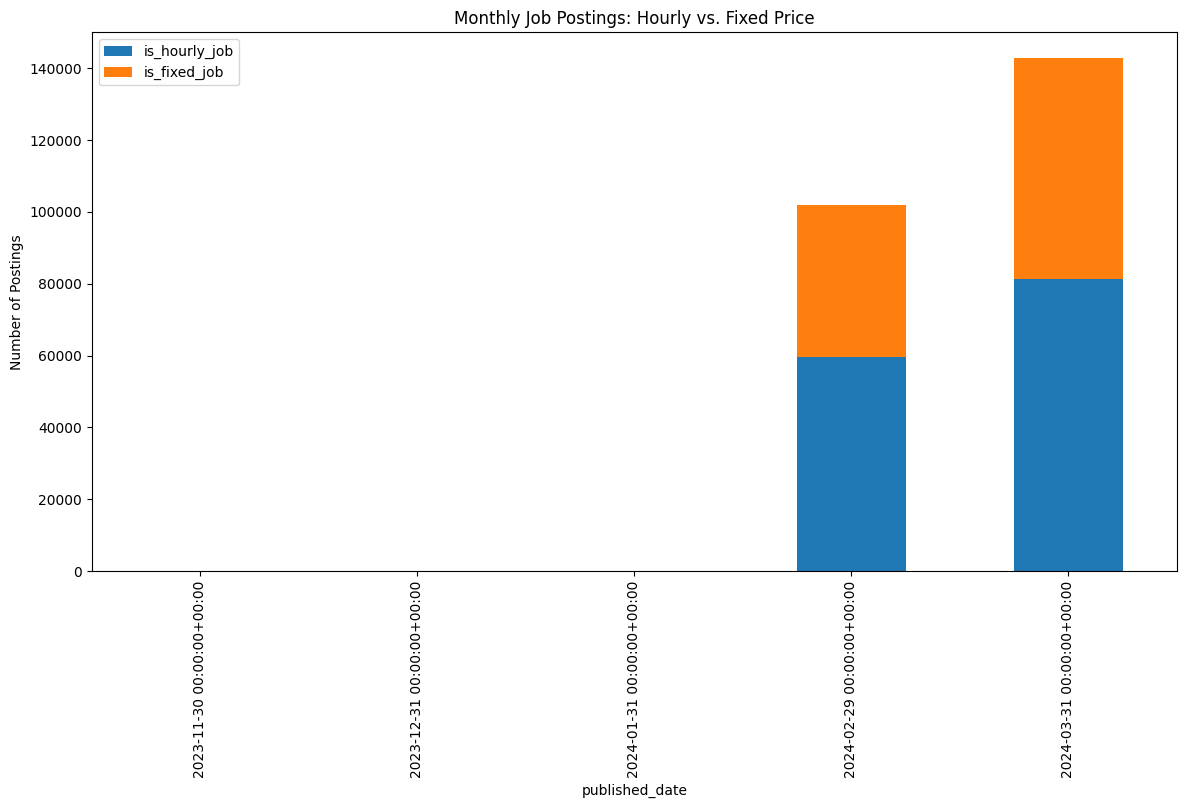

In [ ]:
# Prepare data for the dashboard
# We'll use the time-indexed DataFrame from Task 2
dashboard_data = df_time.copy()

# Count monthly postings for hourly vs. non-hourly
dashboard_data['is_hourly_job'] = dashboard_data['is_hourly']
dashboard_data['is_fixed_job'] = ~dashboard_data['is_hourly']

monthly_summary = dashboard_data[['is_hourly_job', 'is_fixed_job']].resample('ME').sum()

print("\n--- Task 6: Data for Monthly Dynamics Dashboard ---")
print(monthly_summary.tail())

# This DataFrame (monthly_summary) would be used to power a dashboard
# using a tool like Plotly Dash or Flask.
# Example plot for the dashboard:
monthly_summary.plot(kind='bar', stacked=True, figsize=(14, 7), title='Monthly Job Postings: Hourly vs. Fixed Price')
plt.ylabel('Number of Postings')
plt.show()

Task 7: Investigate trends in the remote work landscape


--- Task 7: Remote Work Trends ---
Percentage of job postings mentioning 'Remote':
published_date
2023-11-30 00:00:00+00:00    0.000000
2023-12-31 00:00:00+00:00    0.000000
2024-01-31 00:00:00+00:00    3.125000
2024-02-29 00:00:00+00:00    0.513314
2024-03-31 00:00:00+00:00    0.516684
Freq: ME, Name: is_remote, dtype: float64


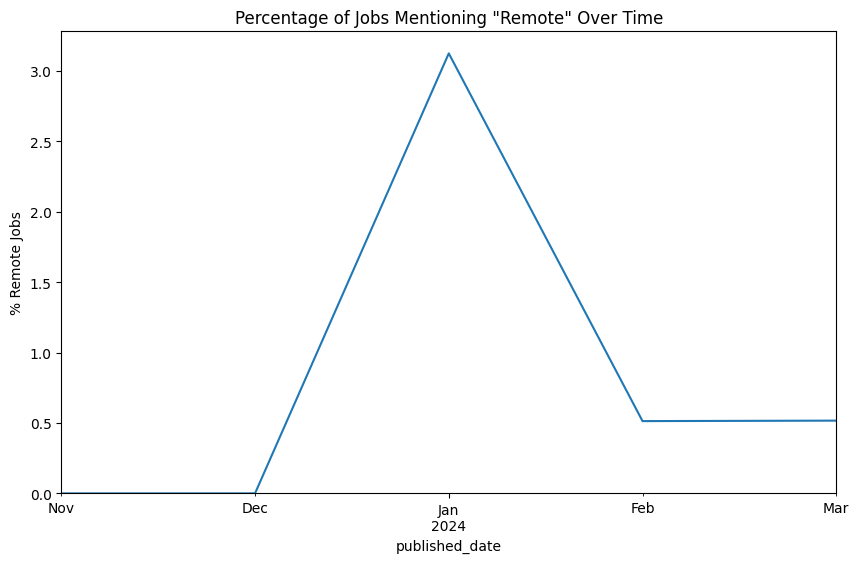

In [ ]:
# Infer remote work from title
df_remote = df_time.copy() # Use df_time which has published_date as index
df_remote['is_remote'] = df_remote['title'].str.contains('remote', case=False, na=False)

# Calculate the percentage of remote jobs over time
monthly_remote_pct = df_remote['is_remote'].resample('ME').mean() * 100

print("\n--- Task 7: Remote Work Trends ---")
print("Percentage of job postings mentioning 'Remote':")
print(monthly_remote_pct.tail())

# Visualize the trend (for the report deliverable [cite: 150153])
monthly_remote_pct.plot(figsize=(10, 6), title='Percentage of Jobs Mentioning "Remote" Over Time')
plt.ylabel('% Remote Jobs')
plt.ylim(0)
plt.show()

Task 8: Predict future job market trends

In [ ]:
# Prepare data for a more advanced model
trend_data_rf = monthly_trends[['Developer']].copy()
trend_data_rf['time'] = np.arange(len(trend_data_rf))
# Create lag features (e.g., jobs last month, 2 months ago)
trend_data_rf['lag_1'] = trend_data_rf['Developer'].shift(1)
trend_data_rf['lag_2'] = trend_data_rf['Developer'].shift(2)
trend_data_rf = trend_data_rf.dropna()

X_rf = trend_data_rf[['time', 'lag_1', 'lag_2']]
y_rf = trend_data_rf['Developer']

# Note: For a real model, we'd use train_test_split and cross-validation
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

# Make a prediction for the next month
last_time = X_rf['time'].iloc[-1]
last_lag_1 = y_rf.iloc[-1]
last_lag_2 = y_rf.iloc[-2]

next_month_features = [[last_time + 1, last_lag_1, last_lag_2]]
next_month_pred = rf_model.predict(next_month_features)

print(f"\n--- Task 8: Predictive Analytics Example ---")
print(f"Predicted 'Developer' jobs for next month: {int(next_month_pred[0])}")


--- Task 8: Predictive Analytics Example ---
Predicted 'Developer' jobs for next month: 8300


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

